<a href="https://colab.research.google.com/github/asim-baral/trash-sorting-classifier/blob/main/Trash_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision import transforms, datasets

from torch.utils.data import DataLoader, random_split

from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class ResizeAndPad:
  def __init__(self, size=(224,224), fill=(0,0,0)):
    self.size = size
    self.fill = fill

  def __call__(self, img):
    img.thumbnail(self.size)
    top = (224 - img.size[1])//2
    bottom = 224 - img.size[1] - top
    left = (224 - img.size[0])//2
    right = (224 - img.size[0]) - left
    padTransform = transforms.Pad((left, top, right, bottom), fill=self.fill)
    return padTransform(img)

In [4]:
transform = transforms.Compose([
    ResizeAndPad(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [5]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dataset = datasets.ImageFolder('/content/drive/MyDrive/colab_datasets/garbage-dataset', transform=transform)

In [7]:
trainSize = int(0.8 * len(dataset))
testSize = len(dataset) - trainSize
trainset, testSet = random_split(dataset, [trainSize, testSize] )

In [8]:
trainDataLoader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
testDataLoader = DataLoader(dataset=testSet, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
res50 = models.resnet50(pretrained = True)
for params in res50.parameters():
  res50.requires_grad=False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


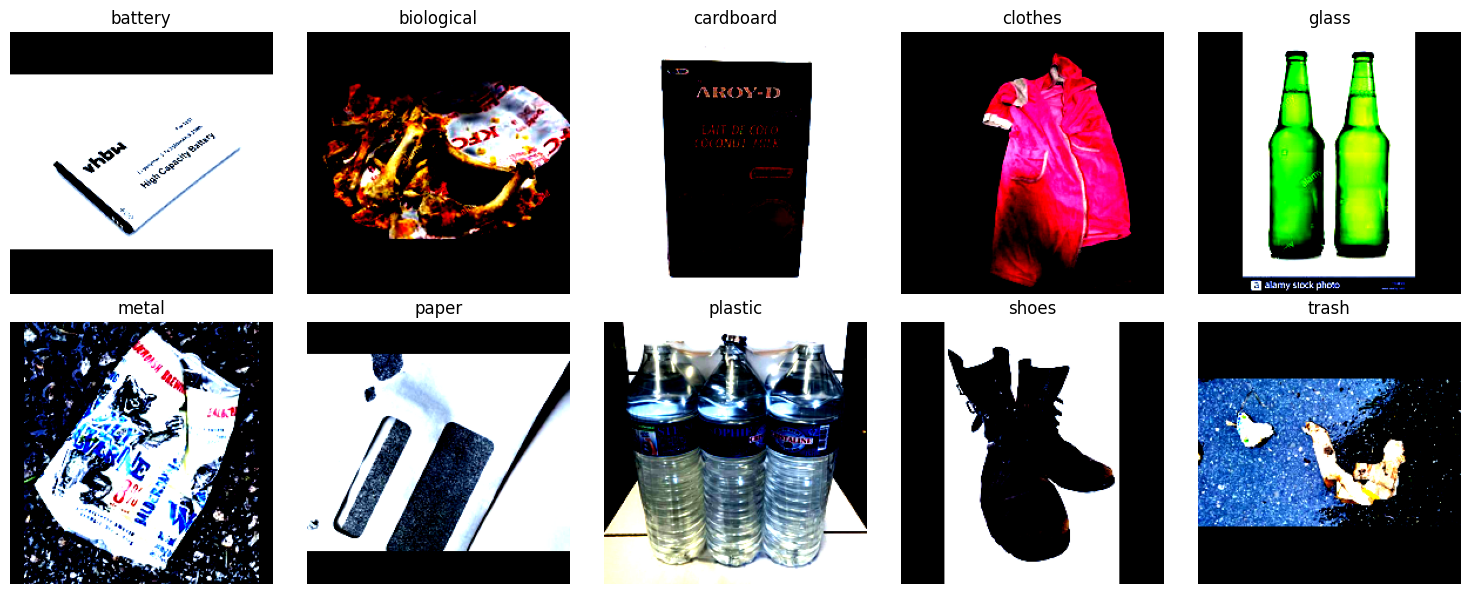

In [10]:
# prompt: Write code to display 1 image of each class, display them in 2 rows, with 5 columns each

import matplotlib.pyplot as plt

# Assuming 'dataset' is your ImageFolder dataset
class_indices = {}
images_to_display = []

for i in range(len(dataset)):
  image, label = dataset[i]
  if dataset.classes[label] not in class_indices:
      class_indices[dataset.classes[label]] = i
      images_to_display.append((image, dataset.classes[label]))

# Display images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (image, label) in enumerate(images_to_display[:10]):
  ax = axes[i // 5, i % 5]
  ax.imshow(image.permute(1, 2, 0))  # Convert tensor to image
  ax.set_title(label)
  ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
res50.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 10),
)

In [12]:
learningRate = 3e-4
numEpochs = 15

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

targets = [label for _, label in dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(class_weights)

tensor([2.0945, 1.9831, 1.0834, 0.3705, 0.6459, 1.9384, 1.1769, 0.9966, 1.0001,
        2.0879], device='cuda:0')


In [14]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(res50.parameters(), lr=learningRate)

In [15]:
res50 = res50.to(device)

for epoch in range(numEpochs):
  totalLoss = 0
  totalSample = 0
  correctPred = 0

  for data, labels in trainDataLoader:
    data = data.to(device)
    labels = labels.to(device)

    #forward pass
    pred = res50(data)

    #loss Calculation
    optimizer.zero_grad()
    loss = criterion(pred, labels)

    #backward pass
    loss.backward()

    #changing parameters
    optimizer.step()

    #calculating loss
    correctPred += (pred.argmax(dim=1) == labels).sum().item()
    totalLoss += loss.item() * len(labels)
    totalSample += len(labels)

  print(f'In epoch:{epoch+1}, Loss={totalLoss/totalSample}, Accuracy={correctPred/totalSample}')


In epoch:1, Loss=0.5716023357401245, Accuracy=0.8466207245368906
In epoch:2, Loss=0.33221183812120075, Accuracy=0.9068091294177151
In epoch:3, Loss=0.2350935172008158, Accuracy=0.9323512676234431
In epoch:4, Loss=0.19290579057296775, Accuracy=0.9439210975532655
In epoch:5, Loss=0.16693881575178088, Accuracy=0.9520136561927041
In epoch:6, Loss=0.15300653502792583, Accuracy=0.9518872099639628
In epoch:7, Loss=0.09197826637170058, Accuracy=0.9726876145918948
In epoch:8, Loss=0.1432493542357945, Accuracy=0.9556805968261997
In epoch:9, Loss=0.09527112254264676, Accuracy=0.9685781121578049
In epoch:10, Loss=0.08607896767745558, Accuracy=0.972497945248783
In epoch:11, Loss=0.0987560246887555, Accuracy=0.9698425744452172
In epoch:12, Loss=0.0940058440669053, Accuracy=0.9718024909907061
In epoch:13, Loss=0.10307470294138481, Accuracy=0.9683252197003225
In epoch:14, Loss=0.04449576156195862, Accuracy=0.9855219068091294
In epoch:15, Loss=0.025483541562870637, Accuracy=0.9914648795599671


Loss=0.33014139142711607, Accuracy=0.9243994943109988


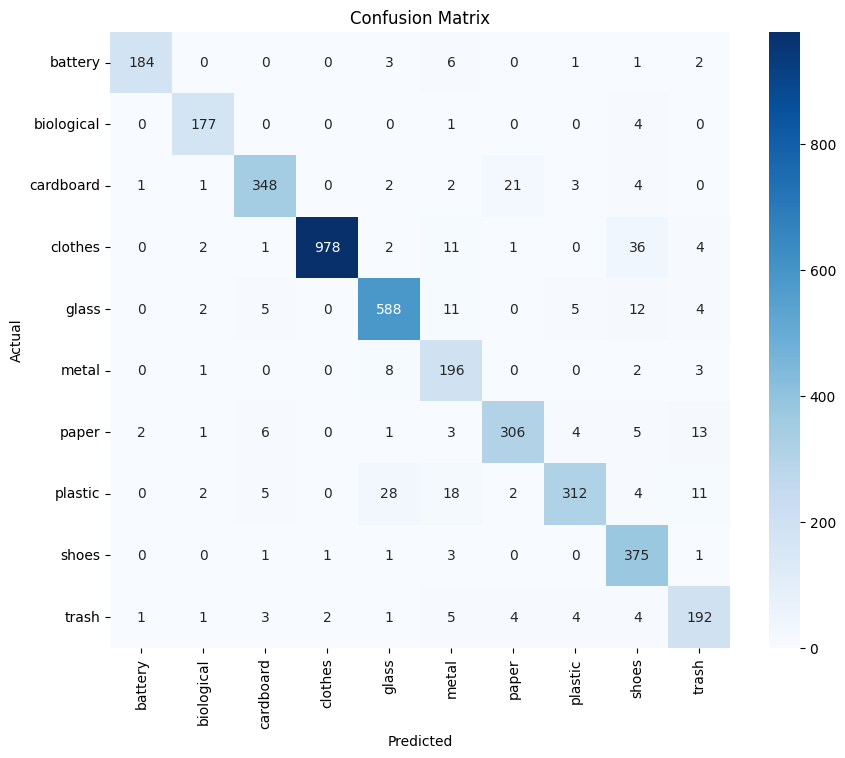

              precision    recall  f1-score   support

     battery       0.98      0.93      0.96       197
  biological       0.95      0.97      0.96       182
   cardboard       0.94      0.91      0.93       382
     clothes       1.00      0.94      0.97      1035
       glass       0.93      0.94      0.93       627
       metal       0.77      0.93      0.84       210
       paper       0.92      0.90      0.91       341
     plastic       0.95      0.82      0.88       382
       shoes       0.84      0.98      0.90       382
       trash       0.83      0.88      0.86       217

    accuracy                           0.92      3955
   macro avg       0.91      0.92      0.91      3955
weighted avg       0.93      0.92      0.93      3955



In [16]:
# prompt: generate code to display confusion matrix and classification report with accuracy and loss aswell

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

res50.eval()

with torch.no_grad():
  totalLoss = 0
  totalSample = 0
  correctPred = 0
  all_predictions = []
  all_labels = []

  for data, labels in testDataLoader:
    data = data.to(device)
    labels = labels.to(device)

    #forward pass
    pred = res50(data)
    loss = criterion(pred, labels)

    correctPred += (pred.argmax(dim=1) == labels).sum().item()
    totalLoss += loss.item() * len(labels)
    totalSample += len(labels)

    # Gather predictions and labels for confusion matrix and classification report
    all_predictions.extend(pred.argmax(dim=1).cpu().numpy())
    all_labels.extend(labels.cpu().numpy())


  print(f'Loss={totalLoss/totalSample}, Accuracy={correctPred/totalSample}')

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_predictions)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=dataset.classes, yticklabels=dataset.classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  # Classification Report
  print(classification_report(all_labels, all_predictions, target_names=dataset.classes))


In [17]:
#saving model
torch.save(res50.state_dict(), '/content/drive/MyDrive/colab_datasets/trash_classifier.pth')  # Save to Drive